In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# importing the required libraries

import os, sys
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

In [ ]:
# some constants for this notebook

INPUT_DIR = "/gdrive/Shareddrives/ALDA_Project/data/final_dataset"
IMAGE_SIDE_SIZE = 128

CLASS_NAMES = ["elliptical", "spiral", "irregular", "invalid"]

OUTPUT_DIR = "/gdrive/Shareddrives/ALDA_Project/data/pca_dataset"

In [ ]:
# loading the images and generating labels 

images = np.zeros(shape = (1, IMAGE_SIDE_SIZE, IMAGE_SIDE_SIZE, 3), dtype = np.float)
labels = np.zeros(shape = (1, ), dtype=np.uint8)
for i in range(len(CLASS_NAMES)):
  temp = np.load(os.path.join(INPUT_DIR, CLASS_NAMES[i]+".npy"))
  temp = temp / 255.
  
  temp_labels = np.ones(shape = (temp.shape[0], ), dtype = np.uint8) * i

  images = np.concatenate((images, temp), axis = 0)

  labels = np.concatenate((labels, temp_labels), axis = 0)

images = images[1:]
labels = labels[1:]
print(images.shape)

NUMBER_IMAGES = images.shape[0]

(3820, 128, 128, 3)


In [ ]:
# sample images
cols = 9
rows = 5

row_images = []

for i in range(rows):
  indices = np.random.rand(cols)
  indices = (indices*NUMBER_IMAGES).astype(np.int64)  

  row = images[indices[0], ...]
  for j in range(1, cols):
    row = np.hstack((row, images[indices[j]]))
  
  row_images.append(row[:])

image = row_images[0]
for i in range(1, rows):
  image = np.vstack((image, row_images[i]))

plt.figure(figsize=(cols*3, rows*3))
plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# we flatten images with np.reshape and demonstrate how they can be brought_back to original_shape

images_flattened = images.reshape(NUMBER_IMAGES, IMAGE_SIDE_SIZE*IMAGE_SIDE_SIZE*3)

In [ ]:
# implementing normalize and de_normalize code

def normalize_z(arr, mean, std, SMOOTH = 0.0001):
  return (arr-mean)/(std+SMOOTH)

def de_normalize_z(arr, mean, std, SMOOTH = 0.0001):
  return arr*(std+SMOOTH) + mean

In [ ]:
# finding mean and std_dev for Z-score normalization

mean = np.mean(images_flattened, axis = 0)
std_dev = np.std(images_flattened, axis = 0)

In [ ]:
# apply normalization on the flattenned images

images_flattened_normalized = normalize_z(images_flattened, mean, std_dev)

In [ ]:
# calculating the total variance present in the images

variance = np.sum(np.std(images_flattened_normalized, axis = 0) ** 2)
print(variance)

49115.92144275305


In [ ]:
# calculating theoritical variance
theoritical_variance = 128*128*3


In [ ]:
#trying out different number of PC's to get an optimal number of PC's 
from sklearn.decomposition import PCA

no_PCs = [1, 2, 4, 8, 16, 32, 64, 128, 256]

explained_variances = []

for no_PC in no_PCs:
  pca = PCA(no_PC)
  X_proj = pca.fit_transform(images_flattened_normalized)

  print(np.sum(pca.explained_variance_))

  explained_variances.append(np.sum(pca.explained_variance_))

34998.272911366395
36777.37949114044
38422.41155002273
40033.789813598916
41425.58102181482
42715.646583538466
43995.16341426391
45350.01017868802
46784.42344352872


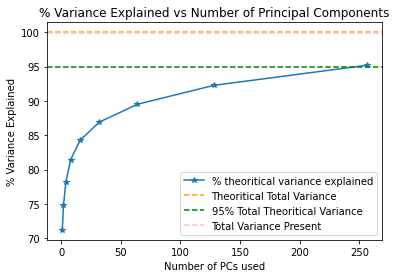

In [ ]:
#plotting the results
explained_variances_percentage = [(explained_variance/theoritical_variance)*100 for explained_variance in explained_variances]

plt.title("% Variance Explained vs Number of Principal Components")
plt.plot(no_PCs, explained_variances_percentage, linestyle = "-", marker = "*", label = "% theoritical variance explained")
plt.axhline(y = 100, color = "orange", linestyle = "--", label = "Theoritical Total Variance")
plt.axhline(y = 95, color = "green", linestyle = "--", label = "95% Total Theoritical Variance")
plt.axhline(y = (variance/theoritical_variance)*100, color = "pink", linestyle = "--", label = "Total Variance Present")
plt.xlabel("Number of PCs used")
plt.ylabel("% Variance Explained")

plt.legend()

In [ ]:
# Reversing the process to get the image from PCA component
images_pcs = pca.transform(images_flattened_normalized)
re_covered_images = pca.inverse_transform(images_pcs)
re_covered_images_de_normalize = de_normalize_z(re_covered_images, mean, std_dev)
recovered = re_covered_images_de_normalize.reshape(NUMBER_IMAGES, IMAGE_SIDE_SIZE, IMAGE_SIDE_SIZE, 3)

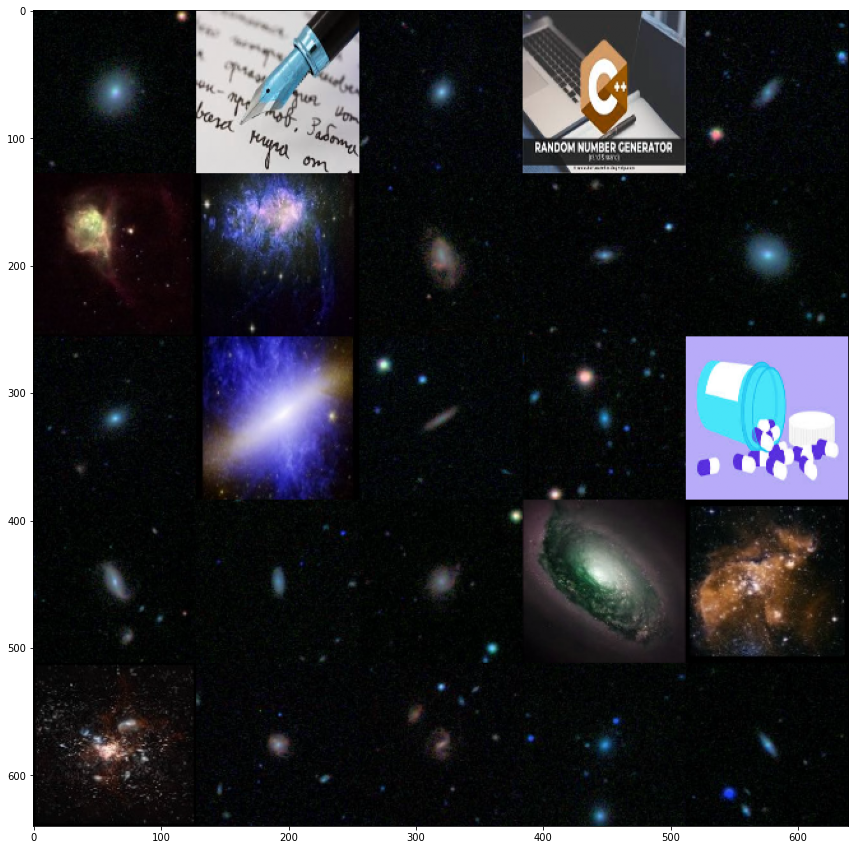

In [ ]:
# sample images
cols = 5
rows = 5
np.random.seed(5)

row_images = []

for i in range(rows):
  indices = np.random.rand(cols)
  indices = (indices*NUMBER_IMAGES).astype(np.int64)  

  row = images[indices[0], ...]
  for j in range(1, cols):
    row = np.hstack((row, images[indices[j]]))
  
  row_images.append(row[:])

image = row_images[0]
for i in range(1, rows):
  image = np.vstack((image, row_images[i]))

plt.figure(figsize=(cols*3, rows*3))
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


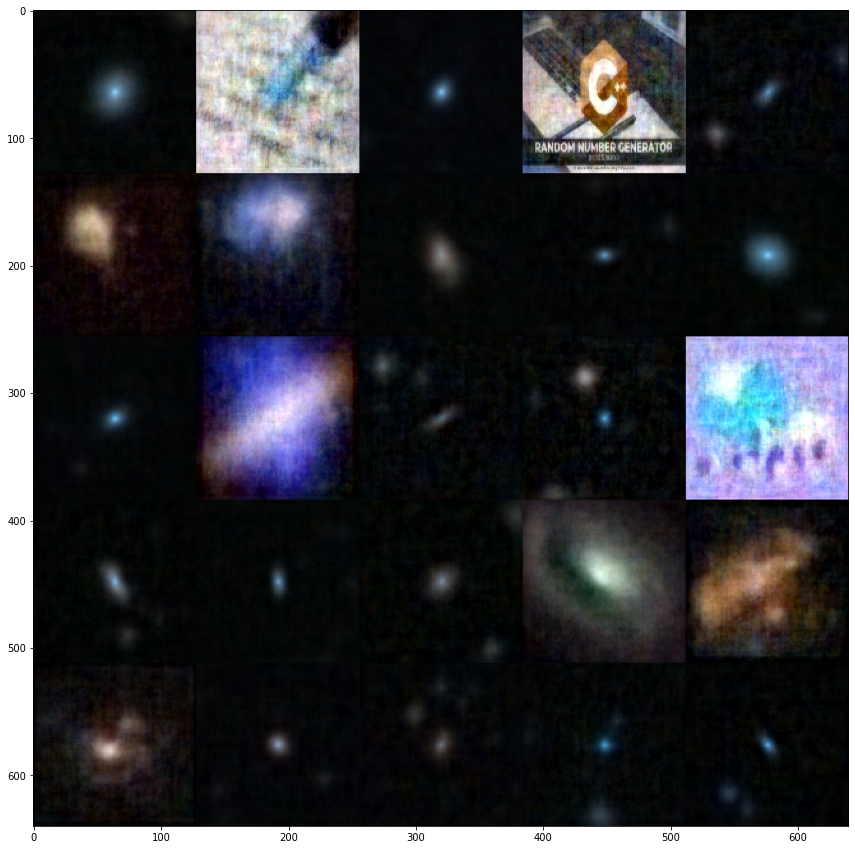

In [ ]:
# sample recovered images
cols = 5
rows = 5
np.random.seed(5)

row_images = []

for i in range(rows):
  indices = np.random.rand(cols)
  indices = (indices*NUMBER_IMAGES).astype(np.int64)  

  row = recovered[indices[0], ...]
  for j in range(1, cols):
    row = np.hstack((row, recovered[indices[j]]))
  
  row_images.append(row[:])

image = row_images[0]
for i in range(1, rows):
  image = np.vstack((image, row_images[i]))

plt.figure(figsize=(cols*3, rows*3))
plt.imshow(image)

In [ ]:
#saving the images in respective paths
np.save(os.path.join(OUTPUT_DIR, "labels.npy"), labels)
np.save(os.path.join(OUTPUT_DIR, "PCs.npy"),  images_pcs)
np.save(os.path.join(OUTPUT_DIR, "images.npy"),  images)